In [1]:
# Initial setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import libraries
import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, interact_manual
import math
import statistics

In [2]:
# Define caminho da imagem
FILEPATH = "img/frames_1/png_rotacionado/"

def analyseImageWithPreview_1(index, thresh):

    global orig, red, th, dst, kernel, dst_open, dst_close, img_height, img_width, cordao, avg_profile, avg_profile_rotated
    
    # Define label
    LABEL = "f_(%d).png" %index
    
    # Define nome do arquivo
    FILENAME = FILEPATH + LABEL
    
    # Carregar a imagem na cor BGR (Padrão Opencv)
    orig = cv2.imread(FILENAME, cv2.IMREAD_COLOR)
    
    print(FILENAME)
    
    # Cropa imagem pela metade
    h = orig.shape[0]
    orig = orig[0:int(h/2),:,:]

    # Converter para RGB
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    
    # Define apenas parte vermelha como array de trabalho
    red = orig[:,:,0]
    
    # Define dimensoes da imagem resultante
    img_height, img_width = red.shape
    
    # Plotar imagens
    fig = plt.figure(figsize = (12,8))
    original_image = plt.imshow(orig)  
    
    plt.figure(figsize = (12,8))
    plt.imshow(red, 'gray')
    
# Selecionar imagem apartir da escolha do usuário
interactive(analyseImageWithPreview_1, index=(0,20), thresh=(0,255))

interactive(children=(IntSlider(value=10, description='index', max=20), IntSlider(value=127, description='thre…

In [114]:
def analyseImageWithPreview(thresh, k_row, k_column):
    
    global th, dst, dst_open, kernel
    
    # Filtra imagem utilizando filtro binario (cria dst)
    th, dst = cv2.threshold(red, thresh, 255, cv2.THRESH_BINARY)
    
    # Refina imagem 
    kernel = np.ones((k_row, k_column), np.uint8)    
    dst_open = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
    
    # Plotar imagens
    plt.figure(figsize = (12,4))
    plt.imshow(dst, 'gray')
    
    plt.figure(figsize = (12,4))
    plt.imshow(dst_open, 'gray')
    
# Selecionar imagem apartir da escolha do usuário
interactive(analyseImageWithPreview, thresh=(0,255), k_row=(1,10), k_column=(1,10))

interactive(children=(IntSlider(value=127, description='thresh', max=255), IntSlider(value=5, description='k_r…

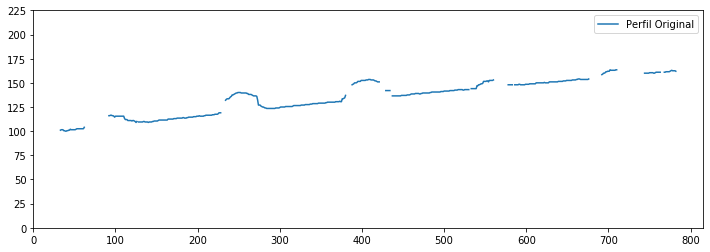

In [115]:
def averageProfileExtractor(img):
    
    global height, width
    
    # Define dimensoes da imagem de entrada
    height, width = img.shape
    
    # Cria array de perfil médio  
    avg_profile = np.array([])
    
    # Loop varrendo cada coluna da imagem de entrada
    for column in range(0, width):
        
        # Array com valor das linhas que contém pixel branco
        column_avg = np.array([])
        
        # Loop em uma coluna adicionando valor da linha de pixels brancos
        for row in range(0, height):
            if img[row,column] > 0:             
                column_avg = np.append(column_avg, row)  
        
        # Adiciona média das linhas ao vetor avg_profile 
        avg_profile = np.append(avg_profile,np.mean(column_avg))     
    
    # Retorna array com perfil médio 
    return avg_profile

# Calcula perfil médio da imagem refinada
avg_profile = averageProfileExtractor(dst_open)  

plt.figure(figsize = (12,4))
original_profile_1, = plt.plot(avg_profile)
original_profile_1.set_label('Perfil Original')
plt.ylim((0,225))
plt.xlim((0,815))
plt.legend()

In [116]:
## Gira imagem baseado em pixels das bordas

### Função para retornar primeiro item não NaN
def firstNonNan(listfloats):
    for item in range(0,len(listfloats)):
        if math.isnan(listfloats[item]) == False:
            return [item,listfloats[item]]

### Função para retornar último item não NaN
def lastNonNan(listfloats):
    for item in reversed(range(0,len(listfloats))):
        if math.isnan(listfloats[item]) == False:
            return [item,listfloats[item]]

### Função para girar imagem        
def rotate_image(mat, angle):
    # angle in degrees

    height, width = mat.shape[:2]
    image_center = (width/2, height/2)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

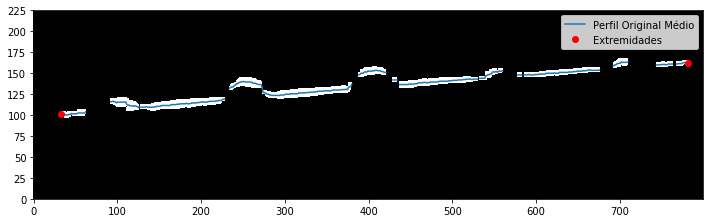

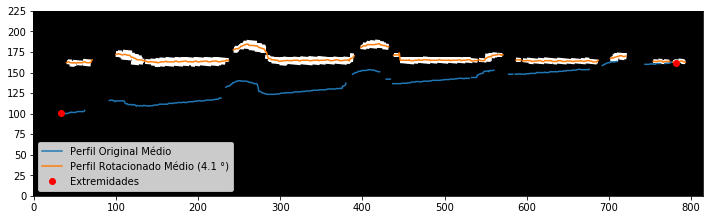

In [117]:
# Salva coordenadas da primeira região em branco [column, rowAvg]
firstPixel = np.array(firstNonNan(avg_profile))

# Salva coordenadas da última região em branco [column, rowAvg]
lastPixel = np.array(lastNonNan(avg_profile))

# Calcula cateto do triângulo formado entre os dois pontos e a horizontal
cathetus  = lastPixel - firstPixel

# Calcula ângulo de inclinação
ang = math.atan(cathetus[1]/cathetus[0])*180/np.pi   

# Cria imagem usando função rotate_image
rotated_image = rotate_image(dst_open, ang)

# Cria perfil médio depois de rotacionar imagem
avg_profile_rotated = averageProfileExtractor(rotated_image)

# Define linha horizontal
bead_bottom = np.nanmin(avg_profile_rotated)

# Define altura maxima
bead_top = np.nanmax(avg_profile_rotated)

plt.figure(figsize = (12,4))
plt.imshow(dst_open, 'gray')
plt.ylim((0,225))

original_profile, = plt.plot(avg_profile)
original_profile.set_label('Perfil Original Médio')
plt.ylim((0,225))

border_pixels, = plt.plot([firstPixel[0], lastPixel[0]], [firstPixel[1], lastPixel[1]], 'ro')
border_pixels.set_label('Extremidades')
plt.legend()

plt.figure(figsize = (12,4))
plt.imshow(rotated_image, 'gray')
plt.ylim((0,225))

original_profile, = plt.plot(avg_profile)
original_profile.set_label('Perfil Original Médio')
plt.ylim((0,225))

rotated_profile, = plt.plot(avg_profile_rotated)
rotated_profile.set_label('Perfil Rotacionado Médio (%d.1 °)' %ang)
plt.ylim((0,225))

border_pixels, = plt.plot([firstPixel[0], lastPixel[0]], [firstPixel[1], lastPixel[1]], 'ro')
border_pixels.set_label('Extremidades')
plt.legend()

## Calcula altura dos cordões

Define referência para linha horizontal

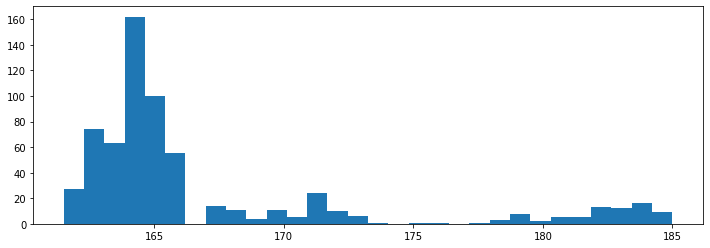

In [118]:
# Plota histograma do perfil médio rotacionado
plt.figure(figsize = (12,4))
plt.hist(avg_profile_rotated,30)

# Define valor da base como sendo a moda da distribuição
base = statistics.mode(avg_profile_rotated) + 2

c:\users\avell\anaconda3\envs\opencv-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 815)

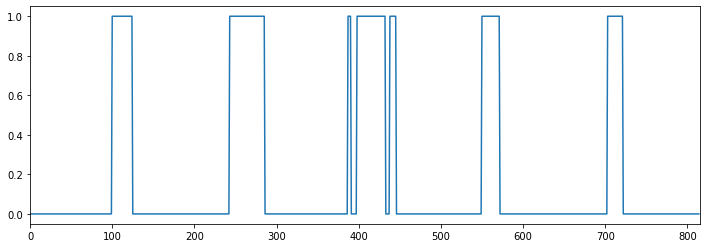

In [119]:
cordao = np.zeros(avg_profile_rotated.shape[0])
cordao[0] = base
cordao = (avg_profile_rotated > base)

plt.figure(figsize = (12,4))
plt.plot(cordao)
plt.xlim((0,815))

(0, 815)

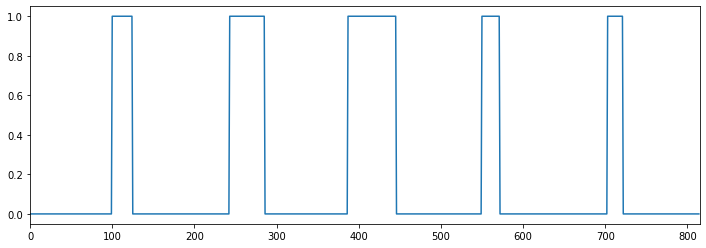

In [120]:
tamanho_vetor = 100

for index in range(0, cordao.shape[0]-tamanho_vetor):

    mudou = False
    p1  = 0
    for x in range(index+1, index+tamanho_vetor):
        if not mudou:
            if cordao[x] != cordao[x-1]:
                p1 = x
                mudou = True
        else:
            if cordao[x] != cordao[x-1]:
                mudou = True
                cordao[p1:x] = cordao[p1]
                
                
plt.figure(figsize = (12,4))
plt.plot(cordao)
plt.xlim((0,815))

In [121]:
minimo = np.nanmin(avg_profile_rotated)
perfil_normalizado = []
altura_normalizada = []
vetores = []
inicio = 0
fim = 0
comecou_cordao = False 

for index in range(0, cordao.shape[0]):        
    if cordao[index] and not comecou_cordao:
            comecou_cordao = True
            inicio = index        
    elif not cordao[index] and comecou_cordao:
        if comecou_cordao == True:
            fim = index
            vetores.append((inicio,fim))
            comecou_cordao = False
    if cordao[index]:
        perfil_normalizado.append(avg_profile_rotated[index] - minimo)
    else:
        perfil_normalizado.append(0)
        
cordoes  = []

for v in vetores:
    inicio, fim = v
    m = avg_profile_rotated[inicio:fim]
    index = np.nanargmax(m)+inicio
    valor = np.nanmax(m) 
    assert valor == avg_profile_rotated[index]
    cordoes.append((index,valor))
    altura_normalizada.append(((index,valor-minimo)))

Cordões: 

[(103, 173.0), (259, 184.5), (419, 185.0), (565, 172.0), (713, 170.5)]


(0, 225)

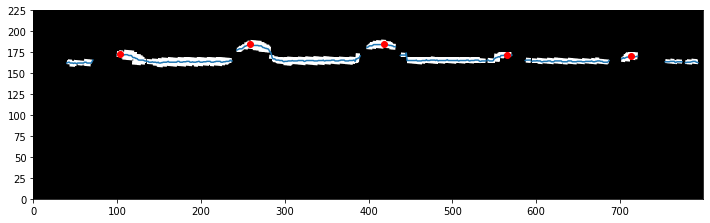

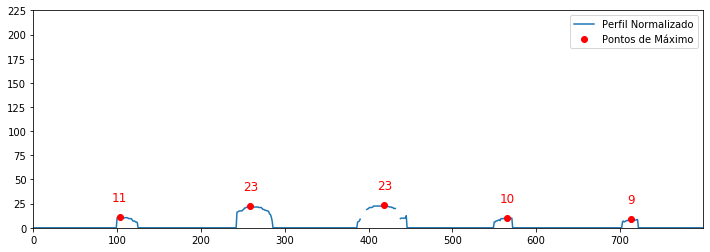

In [122]:
print("Cordões: \n")
print(cordoes)


i = [x[0] for x in vetores]
f = [x[1] for x in vetores]


plt.figure(figsize = (12,4))
plt.plot(avg_profile_rotated)
plt.imshow(rotated_image, 'gray')
plt.plot(*zip(*cordoes), marker='o', color='r', ls='')    
plt.xlim((0,799))
plt.ylim((0,225))


plt.figure(figsize = (12,4))
normalizado, = plt.plot(perfil_normalizado)
normalizado.set_label('Perfil Normalizado')

pontos_maximos, = plt.plot(*zip(*altura_normalizada), marker='o', color='r', ls='')
pontos_maximos.set_label('Pontos de Máximo')

for value in altura_normalizada:
    plt.text(value[0], value[1] + 20, '%d'%value[1], fontsize=12, color='red', horizontalalignment='center',
        verticalalignment='center')

plt.legend()

plt.xlim((0,799))
plt.ylim((0,225))